# Plotting for Airfoil Parameterizations

In [56]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.interpolate import interp1d, splev, splrep, UnivariateSpline
from scipy.stats import norm

# PARSEC Parameterized Airfoil (Truncation optional)

In [59]:
class Parameters(object):
    '''Parameters defining a PARSEC airfoil'''   
    def __init__(self, x):

        if x.size > 6:
            print("5d np array expected")

        front_radius        = x[0]
        x_cross_section     = x[1]
        cross_section_width = x[2]
        sides_curve         = x[3]
        rear_angle          = x[4]
        trunc               = 1
        if x.size > 5:
            trunc               = x[5]
            

        self.r_le       = front_radius              # Leading edge radius
        self.X_up       = x_cross_section           # Upper crest location X coordinate
        self.Z_up       = cross_section_width       # Upper crest location Z coordinate
        self.Z_XX_up    = -sides_curve              # Upper crest location curvature
        self.X_lo       = x_cross_section           # Lower crest location X coordinate
        self.Z_lo       = -cross_section_width      # Lower crest location Z coordinate
        self.Z_XX_lo    = sides_curve               # Lower crest location curvature
        self.Z_te       = 0 # static                # Trailing edge Z coordinate
        self.dZ_te      = 0 # static                # Trailing edge thickness
        self.alpha_te   = 0 # static                # Trailing edge direction angle
        self.beta_te    = rear_angle #(radians)     # Trailing edge wedge angle
        self.P_mix      = 1.0                       # Blending parameter
        self.trunc      = min(trunc,1)              # Where we truncate

In [60]:
class Coefficients(object):
    '''
    Credit for this class goes to
    https://github.com/mbodmer/libairfoil
    This class calculates the equation systems which define the coefficients
    for the polynomials given by the parsec airfoil parameters.
    '''
    def __init__(self, parsec_params):
        self.params = Parameters(parsec_params)
        self._a_up = self._calc_a_up(self.params)
        self._a_lo = self._calc_a_lo(self.params)
    
    def a_up(self):
        '''Returns coefficient vector for upper surface'''
        return self._a_up
    
    def a_lo(self):
        '''Returns coefficient vector for lower surface'''
        return self._a_lo
    
    def _calc_a_up(self, parsec_params):
        Amat = self._prepare_linsys_Amat(parsec_params.X_up)
        Bvec = np.array([parsec_params.Z_te, parsec_params.Z_up,
                            math.tan(parsec_params.alpha_te - parsec_params.beta_te/2),
                            0.0, parsec_params.Z_XX_up, math.sqrt(2*parsec_params.r_le)]) 
        return np.linalg.solve(Amat, Bvec)
    
    def _calc_a_lo(self, parsec_params):
        Amat = self._prepare_linsys_Amat(parsec_params.X_lo)
        Bvec = np.array([parsec_params.Z_te, parsec_params.Z_lo,
                            math.tan(parsec_params.alpha_te + parsec_params.beta_te/2),
                            0.0, parsec_params.Z_XX_lo, -math.sqrt(2*parsec_params.r_le)])
        return np.linalg.solve(Amat, Bvec)
    
    def _prepare_linsys_Amat(self, X):
        return np.array(
            [[1.0,           1.0,          1.0,         1.0,          1.0,          1.0        ],
             [X**0.5,        X**1.5,       X**2.5,      X**3.5,       X**4.5,       X**5.5     ],
             [0.5,           1.5,          2.5,         3.5,          4.5,          5.5        ],
             [0.5*X**-0.5,   1.5*X**0.5,   2.5*X**1.5,  3.5*X**2.5,   4.5*X**3.5,   5.5*X**4.5 ],
             [-0.25*X**-1.5, 0.75*X**-0.5, 3.75*X**0.5, 8.75*X**1.5, 15.75*X**2.5, 24.75*X**3.5],
             [1.0,           0.0,          0.0,         0.0,          0.0,          0.0        ]])

In [70]:
class PARSECAirfoil(object):
    '''
    Credit for this class goes to
    https://github.com/mbodmer/libairfoil
    Airfoil defined by PARSEC Parameters
    '''
    def __init__(self, parsec_params):
        self._coeff = Coefficients(parsec_params)
        
    def Z_up(self, X):
        '''Returns Z(X) on upper surface, calculates PARSEC polynomial'''
        a = self._coeff.a_up()
        X = X * self._coeff.params.trunc
        foil = a[0]*X**0.5 + a[1]*X**1.5 + a[2]*X**2.5 + a[3]*X**3.5 + a[4]*X**4.5 + a[5]*X**5.5
        foil[-1] = 0
        return foil    
    
    def Z_lo(self, X):
        '''Returns Z(X) on lower surface, calculates PARSEC polynomial'''
        a = self._coeff.a_lo()
        X = X * self._coeff.params.trunc
        foil = a[0]*X**0.5 + a[1]*X**1.5 + a[2]*X**2.5 + a[3]*X**3.5 + a[4]*X**4.5 + a[5]*X**5.5
        foil[-1] = 0
        return foil

# NACA Parameterized Airfoil (Truncation optional)

In [20]:
class NACAAirfoil(object):
    '''
    Credit for this class goes to
    https://github.com/mbodmer/libairfoil
    Airfoil defined by PARSEC Parameters
    '''
    def __init__(self, params):
        self.thickness = 1
        self.truncation = params[0]

    def Z_up(self, X):
        X = X * self.truncation
        t = self.thickness
        foil = 5*t * (.2969*np.sqrt(X) - .1260*X - .3516*X**2 + .2843*X**3 - .102*X**4)
        foil[-1] = 0
        return foil

    def Z_lo(self, X):
        '''Returns Z(X) on lower surface, calculates PARSEC polynomial'''
        X = X * self.truncation
        t = self.thickness
        foil = -5*t * (.2969*np.sqrt(X) - .1260*X - .3516*X**2 + .2843*X**3 - .102*X**4)
        foil[-1] = 0
        return foil

# Convex Combo of NACA and PARSEC

In [72]:
class MixAirfoil(object):
    def __init__(self, params):
        self.naca_params = params[0:1]
        self.parsec_params = params[1:7]
        self.mix = params[7]
        self.naca = NACAAirfoil(self.naca_params)
        self.parsec = PARSECAirfoil(self.parsec_params)

    def Z_up(self, X):
        naca_coords = self.naca.Z_up(X)
        parsec_coords = self.parsec.Z_up(X)
        naca_coords = naca_coords * 1/(6*np.max(naca_coords))
        parsec_coords = parsec_coords * 1/(6*np.max(parsec_coords))

        foil = self.mix * naca_coords + (1-self.mix) * parsec_coords
        # foil[-1] = 0
        return foil

    def Z_lo(self, X):
        return -self.Z_up(X)

# Interpolated Airfoil

In [28]:
class InterAirfoil(object):
    def __init__(self, params):
        params = np.array(params)        
        self.x = params[0]

        self.y = np.zeros(params.shape[1])
        for i in range(1,self.y.size):
            self.y[i] = self.y[i-1] + params[1][i-1]
        
        self.f = interp1d(self.x, self.y, kind=1)

    def Z_up(self, X):
        foil = self.f(X)
        foil[-1] = 0
        return foil

    def Z_lo(self, X):
        return -self.Z_up(X)

# Plot Airfoil Designs

In [5]:
def plot_airfoil(airfoil, f=None, l=None, t=None, grid=True, sc=False):
    x = np.linspace(0.0, 1.0, 150)
    foil_up = airfoil.Z_up(x)
    foil_lo = airfoil.Z_lo(x)
    topmax = np.max(foil_up)

    foil_up = foil_up * 1/(6*topmax)
    foil_lo = foil_lo * 1/(6*topmax)
    
    if not sc:
        plt.plot(x, foil_up, 'r--', x,foil_lo, 'b--')
    else:
        plt.plot(x, foil_up, 'k--', linewidth=2)
        plt.plot(x, foil_lo, 'k--', linewidth=2)
    
    
    plt.xlim(-.1, 1.1)
    plt.ylim(-.3, .3)
    if l is not None:
        plt.xlabel(l)
    plt.gca().set_aspect('equal', adjustable='box')
    if grid:
        plt.grid(True)
    if t is not None:
        plt.title(t)
    if f is None:
        plt.show()
    else:
        plt.savefig(f)
    plt.close()

### Example optimization history

In [18]:
designs = [
[0.4, 0.26, 0.26, 2.2, 0.628, 0.9],
[0.395, 0.27, 0.27, 2.14, 0.629, 0.873],
[0.385, 0.24, 0.303, 2.256, 0.656, 0.743],
[0.399, 0.252, 0.287, 2.205, 0.629, 0.835],
[0.397, 0.247, 0.291, 2.255, 0.62, 0.826],
[0.399, 0.245, 0.29, 2.282, 0.615, 0.825],
[0.396, 0.247, 0.292, 2.266, 0.613, 0.826],
[0.397, 0.247, 0.293, 2.277, 0.61, 0.822],
[0.397, 0.246, 0.293, 2.28, 0.612, 0.823],
[0.397, 0.246, 0.293, 2.282, 0.611, 0.822],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.821],
[0.397, 0.246, 0.294, 2.284, 0.61, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.61, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.284, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
[0.397, 0.246, 0.294, 2.283, 0.611, 0.82],
]

objs = [
    1.0577, 0.964, 0.7568, 0.678, 0.6294, 0.6307,
    0.6289, 0.6296, 0.7706, 0.6306, 0.6307, 0.6318,
    0.631, 0.6397, 0.6312, 0.7581, 0.6314, 0.6304,
    0.6312, 0.6312, 0.6318, 0.6319, 0.6319, 0.6319,
    0.6335, 0.6226
]

## Plot succession of images for animation

In [57]:
def plot_anim(designs, objs, basef="./myopt/anim/iter", Airfoil=None):
    for i in range(len(designs)):
        params = designs[i]
        params = Parameters(np.array(params))
        airfoil = Airfoil(params)
        iter = str(i+1)
        iter = '0'*(4-len(iter)) + iter
        filename = basef + iter + ".png"
        label = "Iter: " + iter + "    Obj: {:.4f}".format(objs[i])
        plot_airfoil(airfoil, f=filename, l=label)

In [71]:
# plot_anim(designs, objs, Airfoil=PARSECAirfoil)

### Construct ticks for Interpolated Airfoil

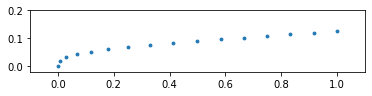

In [50]:
xticks = np.linspace(0,np.pi/2,10)
xticks = np.array([(0.5*(1.0-np.cos(tick))) for tick in xticks])
xticks = np.hstack([xticks, np.linspace(0.5,1,7)[1:]])

plt.scatter(xticks, [np.log(1+i*.01)**.7/2 for i in range(len(xticks))], s=8)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-.1,1.1)
plt.ylim(-.02,.2)
plt.show()
plt.clf()

### Example of how to get init params for interpolated airfoil from mixed airfoil

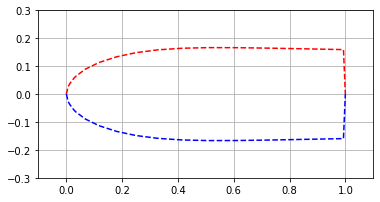

[0.031, 0.03, 0.028, 0.024, 0.02, 0.015, 0.01, 0.006, 0.002, 0.0, -0.001, -0.001, -0.002, -0.002, -0.002]


In [62]:
params = np.array([0.441, 0.425, 0.234, 0.293, 2.222, 0.661, 0.496, 0.307])
airfoil = MixAirfoil(params)

ys = airfoil.Z_up(xticks)
ys[-1] = 2*ys[-2]-ys[-3]
ys_rel = [ ys[i+1] - ys[i] for i in range(len(ys)-1)]

rec = np.zeros(len(ys))
for i in range(1,len(ys)):
    rec[i] = rec[i-1] + ys_rel[i-1]

params = np.zeros((2,len(xticks)))
params[0] = xticks
params[1,:-1] = ys_rel

airfoil = InterAirfoil(params)
plot_airfoil(airfoil)

print(list(np.around(ys_rel,decimals=3)))

### Example of plotting with interpolated points marked

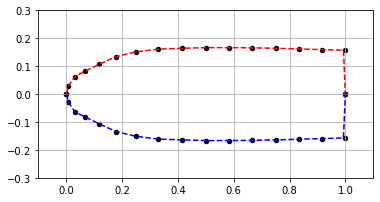

In [63]:
ys_rel = [0.036, 0.042, 0.024, 0.03, 0.035, 0.021,
          0.012, 0.004, 0.003, -0.0, -0.001, -0.002,
          -0.003, -0.003, -0.003]
params = np.zeros((2,len(xticks)))
params[0] = xticks
params[1,:-1] = ys_rel
airfoil = InterAirfoil(params)

xs_plt = np.hstack([params[0],np.ones(1)])

ys_air = airfoil.Z_up(xs_plt)
ys_air = ys_air / (ys_air.max()*6)
plt.scatter(xs_plt,ys_air, s=20, c="black")
plt.scatter(xs_plt,-1*ys_air, s=20, c="black")

plot_airfoil(airfoil)





### Wind speeds experienced usually roughly ~Normal(0,6)

[6.641, 6.55, 6.283, 5.863, 5.321, 4.697, 4.033, 3.368, 2.736, 2.162, 1.661]


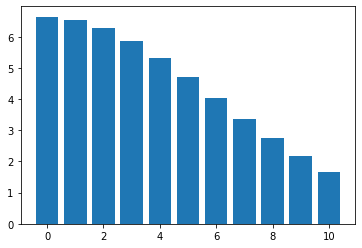

In [66]:
rv = norm(loc=0, scale=6)
weights = np.array([rv.cdf(i+.5)-rv.cdf(i-.5) for i in range(11)])
weights *= 100
print(list(np.around(weights,decimals=3)))
plt.bar(range(11),weights)
plt.show()

# Plotting Final Results

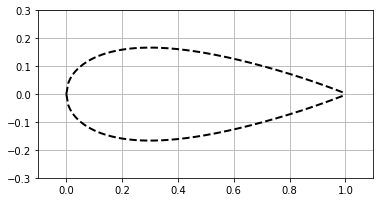

8.671495388386187


In [67]:
# NACA #
params = [1]

NACA_airfoil = NACAAirfoil(params)
plot_airfoil(NACA_airfoil, sc=True, grid=True)

NACA_drags = [.1614,.17196,.1726,.1549,.1890,.1877,.1896,.1888,.1784,.1814,.1882]
NACA_obj = np.dot(weights, NACA_drags)

print(NACA_obj)

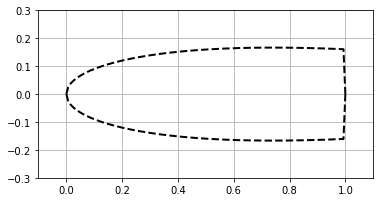

3.4682574720337005


In [68]:
# Truncated NACA #
params = [0.405]

T_NACA_airfoil = NACAAirfoil(params)
plot_airfoil(T_NACA_airfoil, sc=True, grid=True)

T_NACA_drags = [0.05762, 0.05822, 0.06011, 0.06368, 0.07056, 0.08613, 0.10899, 0.08041, 0.06907, 0.06685, 0.07789]
T_NACA_obj = np.dot(weights, T_NACA_drags)

print(T_NACA_obj)

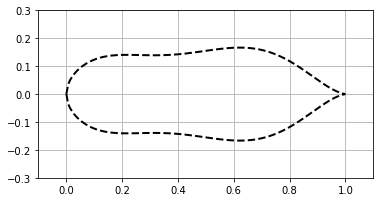

5.411919901807162


In [73]:
# PARSEC #
params = np.array([0.409, 0.217, 0.293, 2.334, 0.683])

PARSEC_airfoil = PARSECAirfoil(params)
plot_airfoil(PARSEC_airfoil, sc=True, grid=True)

PARSEC_drags = [0.08049, 0.08301, 0.08778, 0.08862, 0.08862, 0.0949, 0.1101, 0.18464, 0.18998, 0.19663, 0.20138]

PARSEC_obj = np.dot(weights, PARSEC_drags)

print(PARSEC_obj)


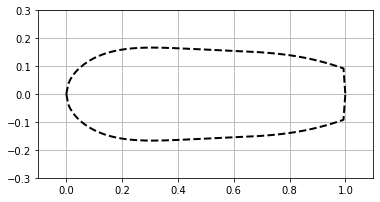

4.672644688767201


In [74]:
# Truncated PARSEC #
params = np.array([0.3997, 0.2453, 0.3009, 2.3359, 0.618, 0.7968])

T_PARSEC_airfoil = PARSECAirfoil(params)
plot_airfoil(T_PARSEC_airfoil, sc=True, grid=True)

T_PARSEC_drags = [0.0563, 0.06555, 0.07176, 0.07381, 0.07902, 0.08963, 0.108, 0.16884, 0.16884, 0.17409, 0.1817]
T_PARSEC_obj = np.dot(weights, T_PARSEC_drags)

print(T_PARSEC_obj)

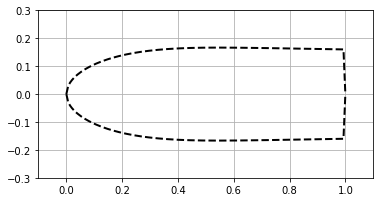

3.473527948748136


In [75]:
# Mixed #
params = np.array([0.4388, 0.4285, 0.2319, 0.2924, 2.2184, 0.6653, 0.4959, 0.3065])

Mix_airfoil = MixAirfoil(params)
plot_airfoil(Mix_airfoil, sc=True, grid=True)

Mix_drags = [0.0588735, 0.0588735, 0.05607, 0.08192, 0.07034, 0.07065, 0.07377, 0.07822, 0.08443, 0.0926, 0.09999]
Mix_obj = np.dot(weights, Mix_drags)

print(Mix_obj)

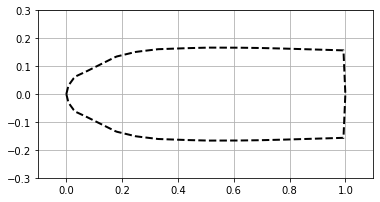

2.9630834688780094


In [76]:
# Interpolated #
x = [0.0372, 0.0374, 0.0204, 0.0301, 0.0367, 0.0206, 0.0114, 0.0038, 0.003, 0.0001, -0.001, -0.0021, -0.0031, -0.003, -0.003]

ticks = np.linspace(0,np.pi/2,10)
ticks = np.array([(0.5*(1.0-np.cos(e))) for e in ticks])
ticks = np.hstack([ticks, np.linspace(0.5,1,7)[1:]])
params = np.zeros((2,len(ticks)))
params[0] = ticks
params[1,:-1] = x

Inter_airfoil = InterAirfoil(params)
plot_airfoil(Inter_airfoil, sc=True, grid=True)

Inter_drags = [0.05307, 0.05478, 0.06334, 0.0615, 0.06088, 0.06085, 0.06132, 0.06208, 0.06323, 0.06509, 0.0683]
Inter_obj = np.dot(weights, Inter_drags)

print(Inter_obj)

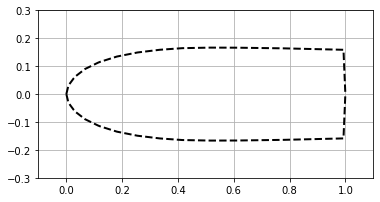

3.4526324763027545


In [77]:
# Interpolated From NACA #
x = [0.0312, 0.0304, 0.0284, 0.0243, 0.0198, 0.0145, 0.0099, 0.0061, 0.002, 0.0001, -0.001, -0.001, -0.002, -0.002, -0.002]

ticks = np.linspace(0,np.pi/2,10)
ticks = np.array([(0.5*(1.0-np.cos(e))) for e in ticks])
ticks = np.hstack([ticks, np.linspace(0.5,1,7)[1:]])
params = np.zeros((2,len(ticks)))
params[0] = ticks
params[1,:-1] = x

Inter2_airfoil = InterAirfoil(params)
plot_airfoil(Inter2_airfoil, sc=True, grid=True)

Inter2_drags = [0.060648, 0.060648, 0.05776, 0.076755, 0.0731, 0.07078, 0.07279, 0.07595, 0.08126, 0.08869, 0.09324]
Inter2_obj = np.dot(weights, Inter2_drags)

print(Inter2_obj)

## Save a plot of each airfoil

In [78]:
airfoils = [NACA_airfoil, PARSEC_airfoil, T_NACA_airfoil, T_PARSEC_airfoil, Mix_airfoil, Inter_airfoil, Inter2_airfoil]
names = ["NACA", "PARSEC", "Truncated NACA", "Truncated PARSEC", "Convex Combination", "Interpolated from Mixed", "Interpolated from NACA"]
objs = [NACA_obj, PARSEC_obj, T_NACA_obj, T_PARSEC_obj, Mix_obj, Inter_obj, Inter2_obj]
drags = [NACA_drags, PARSEC_drags, T_NACA_drags, T_PARSEC_drags, Mix_drags, Inter_drags, Inter2_drags]

plt.rc('font', size=6)          # controls default text sizes
plt.rc('axes', titlesize=10)     # fontsize of the axes title
plt.rc('axes', labelsize=6)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=7)    # fontsize of the tick labels
plt.rc('ytick', labelsize=7)    # fontsize of the tick labels
plt.rc('figure', titlesize=12)  # fontsize of the figure title

for i in range(len(airfoils)):
    print(names[i], "\nObj:", objs[i])
    # a_drag = np.hstack([drags[i][::-1],drags[i][1:]])
    # yaws = len(drags[i])
    # yaws = list(range(-yaws+1,yaws))
    # plt.ylim(0, a_drag.max()+.02)
    # plt.plot(yaws,a_drag)
    # plt.show()
    t = names[i] + "        Obj: " + str(np.around(objs[i],decimals=3))
    plot_airfoil(airfoils[i], sc=True, grid=True, f=names[i], t=t)

NACA 
Obj: 8.671495388386187
PARSEC 
Obj: 5.411919901807162
Truncated NACA 
Obj: 3.4682574720337005
Truncated PARSEC 
Obj: 4.672644688767201
Convex Combination 
Obj: 3.473527948748136
Interpolated from Mixed 
Obj: 2.9630834688780094
Interpolated from NACA 
Obj: 3.4526324763027545


## Drag vs Yaw plot

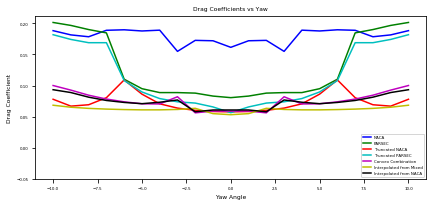

In [79]:
colors = ["b", "g", "r", "c", "m", "y", "k"]

plt.rc('font', size=6)          # controls default text sizes
plt.rc('axes', titlesize=6)     # fontsize of the axes title
plt.rc('axes', labelsize=6)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=4)    # fontsize of the tick labels
plt.rc('ytick', labelsize=4)    # fontsize of the tick labels
plt.rc('figure', titlesize=10)  # fontsize of the figure title

plt.ylim(0,np.max(drags))
plt.title("Drag Coefficients vs Yaw")
plt.xlabel("Yaw Angle")
plt.ylabel("Drag Coefficient")
for i in range(len(airfoils)):
    a_drag = np.hstack([drags[i][::-1],drags[i][1:]])
    yaws = len(drags[i])
    yaws = list(range(-yaws+1,yaws))
    plt.plot(yaws,a_drag, label=names[i], c=colors[i])

plt.gca().set_aspect(35, adjustable='box')
plt.ylim(-.05, np.max(drags)+.01)
plt.legend(loc=4, prop={'size': 4})
plt.tight_layout()
plt.savefig('dragyaw', dpi=1200)
plt.show()